## Fetching data


In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

## Open file

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing ["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


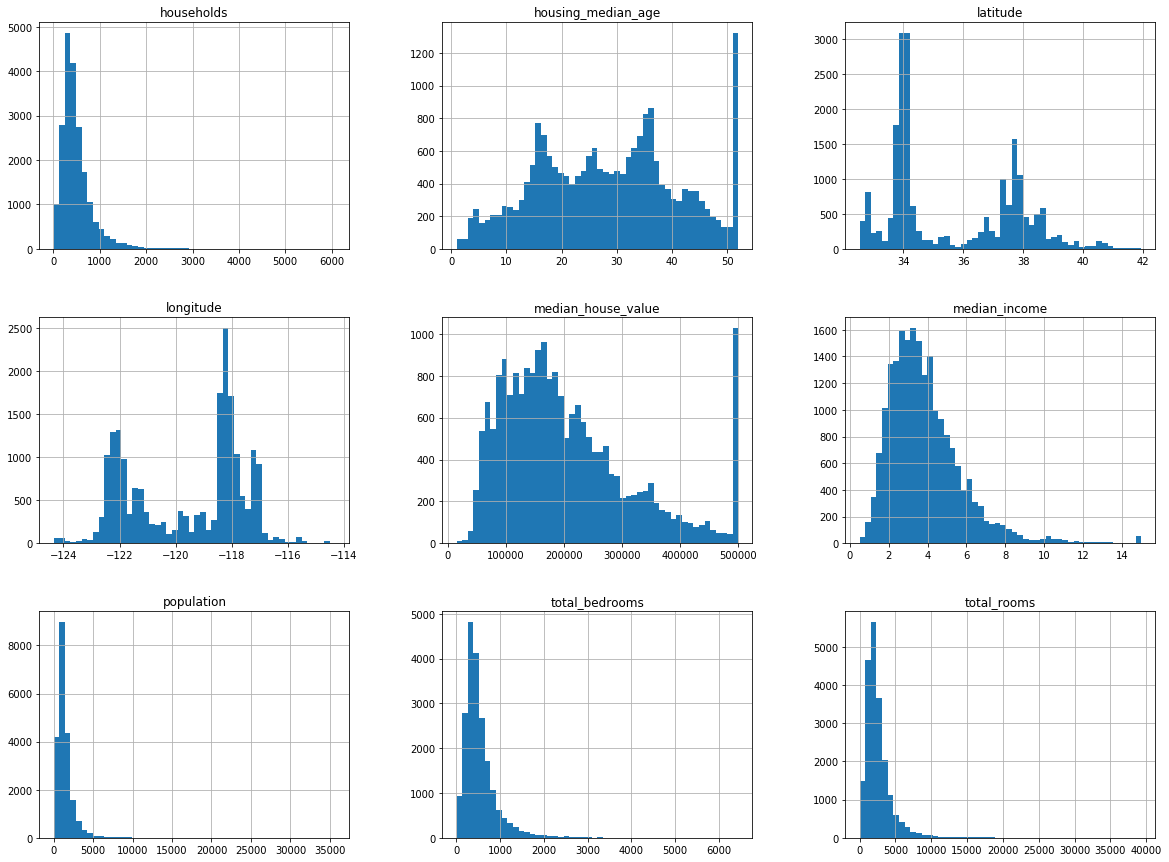

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()


## Create a test set
### 主要目的為產生一組不變的testing set
#### 法一

In [10]:
import numpy as np
np.random.seed(42)
def split_train_test(data, test_ratio):
    # test_ratio : test set 比例
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # 最後 'test set size'筆資料
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print (len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


缺點為即使random seed 可固定random序列，每一次開啟程式皆會產生不同亂數。

* 解決方式：使用identifier hashing計算各資料ID，決定是否進入test set，如此可固定test set
### 法二

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    # hash().digest()[-1] : last value of the hash digest
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

* 若資料沒有identifier，可用編號。

In [13]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

* 若用index，需確認新資料update在最後，且沒有資料被刪除。
可以用長寬(不易改變之數值，且不受插入位置影響)。

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

scikit-learn套件有專門之分類函式。

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## stratified
將資料分類成固定範圍，為保證資料重要性不被稀釋，各範圍不可太細。

In [16]:
# 在資料中新增一欄用來分類，把income/1.5為一組，>5收斂到 5。
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [17]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


## 利用scikit_learn 工具來分資料，其比亂數取資料更可還原training set 之特性。

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
print ("train set: \n"+str(strat_train_set["income_cat"].value_counts()/len(strat_train_set)))
print ()
print ("test set : \n"+str(strat_test_set["income_cat"].value_counts()/len(strat_test_set)))

train set: 
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

test set : 
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


## 分類資料完成，拿掉income_cat使資料變為原格式

In [20]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND


## 分類完成，把test set 封存，接下來只看training set
把training set 複製一份來觀察

In [21]:
housing = strat_train_set.copy()


#### visualizing data

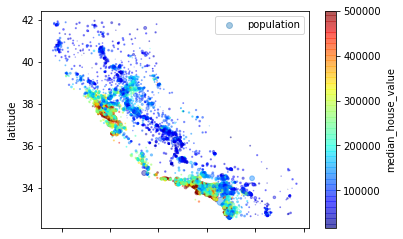

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4, \
            s=housing["population"]/500, label="population", \
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar="False")
plt.legend()

### correlation between data
可觀察各資料之間的相關性

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### 用pandas tool : scatter matrix處理不同data的相關度可視化

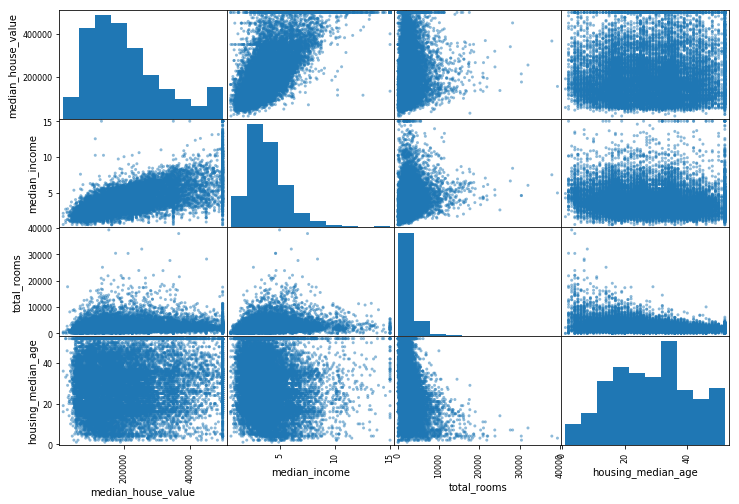

In [24]:
from pandas.plotting import scatter_matrix
attrib = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attrib], figsize=(12, 8));

median house value和median income最有關

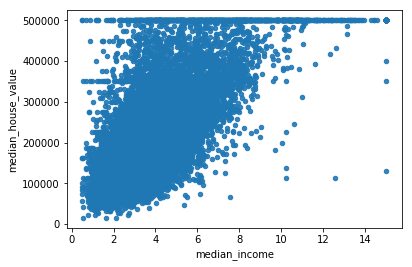

In [25]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.9);

增加其他資料關係

In [26]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [27]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014FC5B52780>,
      dtype=object)

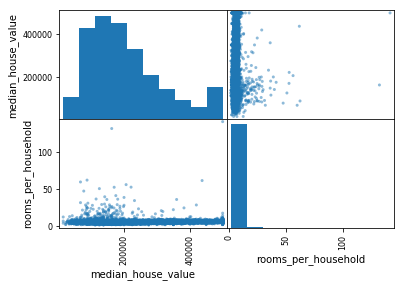

In [28]:
attrib = ["median_house_value", "rooms_per_household"]
scatter_matrix(housing[attrib])

重新準備資料

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning
處理資料缺失問題，方法有三種：
* 去掉該筆資料 (housing.dropna)
* 去掉該特徵 (housing.drop)
* 想辦法設值 (housing.fillna)

In [30]:
#housing.dropna(subset=["total_bedrooms"])            # option 1

#housing.drop("total_bedrooms", axis=1)               # option 2

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)             # option 3

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Le

### 萬能的 sklearn當然也有相應的funciton XDD

In [31]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

要注意的是，ocean_proximity是string type，因此使用 Imputer時要拿掉。

In [32]:
housing_num = housing.drop("ocean_proximity", axis = 1)

In [33]:
imputer.fit(housing_num)  # 讓 imputer算出 median

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

此資料中只有 total_bedroom有 missing value，但Imputer會把全部的 median算出來，況且你也不能確認資料一定沒有缺失。

In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [35]:
housing.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

接下來把 imputer用在資料上：

In [36]:
result = imputer.transform(housing_num)
result

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

然後你會發現 result資料型態不是dataframe，而是 numpy array，所以用 pandas.DataFrame()塞回去。

In [37]:
housing_ready_for_training = pd.DataFrame(result, columns= housing_num.columns)

In [46]:
housing_ready_for_training.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [42]:
housing_ready_for_training.to_csv("datasets/fetching_data_housing", index=False)